In [1]:
!pip install timm -q

In [2]:
import os

base = "/kaggle/input"

print(os.listdir(base))

['datasets']


In [3]:
import os

print(os.listdir("/kaggle/input/datasets"))

['himanshurajput123', 'harshit1631']


In [4]:
import os

print(os.listdir("/kaggle/input/datasets/harshit1631"))


['mixeddatasetcapsularendoscopy1', '61-csv']


In [5]:
import os

path = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1"

print(os.listdir(path))

['Dataset']


In [6]:
import os

base = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset"

print(os.listdir(base))

['validation', 'training']


In [7]:
import os

train_path = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/training"

classes = sorted(os.listdir(train_path))
print(classes)

['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms', 'training_data.xlsx', '~$training_data.xlsx']


In [8]:
import os

train_path = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/training"

classes = sorted([
    f for f in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path,f))
])

print(classes)

['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class GI_Dataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        self.classes = sorted([
            f for f in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir,f))
        ])

        self.class_to_idx = {cls:i for i,cls in enumerate(self.classes)}

        for cls in self.classes:
            class_path = os.path.join(root_dir,cls)

            for subfolder in os.listdir(class_path):

                sub_path = os.path.join(class_path,subfolder)
                if not os.path.isdir(sub_path):
                    continue

                for file in os.listdir(sub_path):
                    if file.lower().endswith(".jpg"):
                        self.paths.append(os.path.join(sub_path,file))
                        self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,idx):

        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img,label

In [10]:
from torchvision import transforms

train_path = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/training"
val_path   = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/validation"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = GI_Dataset(train_path, transform)
val_ds   = GI_Dataset(val_path, transform)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Classes:", train_ds.classes)

Train size: 37607
Val size: 16132
Classes: ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=2)
val_loader   = DataLoader(val_ds,batch_size=32,shuffle=False,num_workers=2)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 1176
Val batches: 505


In [12]:
import numpy as np

counts = np.bincount(train_ds.labels)

for cls,count in zip(train_ds.classes,counts):
    print(cls,":",count)

Angioectasia : 1154
Bleeding : 834
Erosion : 2694
Erythema : 691
Foreign Body : 792
Lymphangiectasia : 796
Normal : 28663
Polyp : 1162
Ulcer : 663
Worms : 158


In [13]:
import torch
import numpy as np

counts = np.bincount(train_ds.labels)

weights = 1.0 / counts
weights = weights / weights.sum()

class_weights = torch.tensor(weights,dtype=torch.float32).cuda()

print(class_weights)

tensor([0.0573, 0.0792, 0.0245, 0.0956, 0.0834, 0.0830, 0.0023, 0.0569, 0.0997,
        0.4182], device='cuda:0')


In [14]:
import timm
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "efficientnet_b4",
    pretrained=True,
    num_classes=len(train_ds.classes)
)

model = model.to(device)

print("Model ready")

Model ready


In [15]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

print("Backbone frozen")

Backbone frozen


In [16]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=0.001
)

print("Loss and optimizer ready")

Loss and optimizer ready


In [17]:
EPOCHS = 5
best_acc = 0

for epoch in range(EPOCHS):

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # -------- TRAIN --------
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:

        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("Train Loss:", total_loss/len(train_loader))


    # -------- VALIDATION --------
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print("Validation Accuracy:", acc)


    # -------- SAVE BEST MODEL --------
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")


Epoch 1/5
Train Loss: 1.7680672648660585
Validation Accuracy: 0.6110215720307464
Best model saved

Epoch 2/5
Train Loss: 1.3127236043540191
Validation Accuracy: 0.606744359037937

Epoch 3/5
Train Loss: 1.1702157877841775
Validation Accuracy: 0.624907017108852
Best model saved

Epoch 4/5
Train Loss: 1.0943280679686946
Validation Accuracy: 0.6722043144061493
Best model saved

Epoch 5/5
Train Loss: 1.0320059174963203
Validation Accuracy: 0.672452268782544
Best model saved


In [18]:
for param in model.parameters():
    param.requires_grad = False

# unfreeze last block + classifier
for param in model.blocks[-1].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

print("Last layers unfrozen")

Last layers unfrozen


In [19]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)

print("Fine-tuning optimizer ready")

Fine-tuning optimizer ready


In [20]:
EPOCHS = 3

for epoch in range(EPOCHS):

    print(f"\nFineTune Epoch {epoch+1}/{EPOCHS}")
    
    # TRAIN
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:

        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("Train Loss:", total_loss/len(train_loader))


    # VALIDATION
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print("Validation Accuracy:", acc)


FineTune Epoch 1/3
Train Loss: 0.9735261340226445
Validation Accuracy: 0.6890032234068931

FineTune Epoch 2/3
Train Loss: 0.9320317036567294
Validation Accuracy: 0.692970493429209

FineTune Epoch 3/3
Train Loss: 0.9112947426964434
Validation Accuracy: 0.6935283907760972


In [21]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("Best model loaded")

Best model loaded


In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:\n")
print(cm)

Confusion Matrix:

[[ 235   11   99   25   18   32   26   39    8    4]
 [   7  232   38   16   17   10    6   25    4    4]
 [  46   66  501  153   81   57   85  103   40   23]
 [  12   12   70  119    5    7   25   41    3    3]
 [   7    3   24   10  248   15   15    9    7    2]
 [  14    5   33   10   18  216   23   15    9    0]
 [ 424  230  538  440  576  404 8783  372  429   91]
 [  15   22   86   74   31   49   12  199    2   10]
 [   1    2    2    6    3    0    7    4  250   11]
 [   0    0    0    0    0    0    1    1    1   65]]


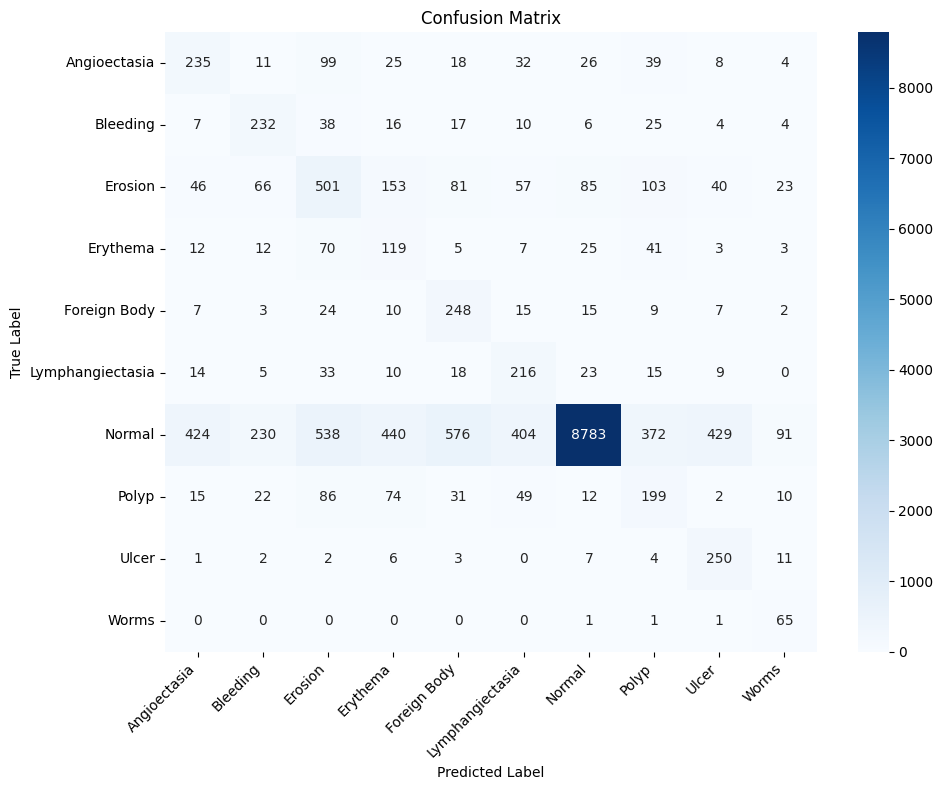

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = train_ds.classes
cm_array = np.array(cm)

plt.figure(figsize=(10,8))

sns.heatmap(
    cm_array,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [24]:
import pandas as pd
import numpy as np

cm_array = np.array(cm)

per_class_acc = cm_array.diagonal() / cm_array.sum(axis=1)

df = pd.DataFrame({
    "Class": train_ds.classes,
    "Accuracy": per_class_acc
}).sort_values("Accuracy", ascending=False)

df

Class  Accuracy
9             Worms  0.955882
8             Ulcer  0.874126
4      Foreign Body  0.729412
6            Normal  0.714821
1          Bleeding  0.646240
5  Lymphangiectasia  0.629738
0      Angioectasia  0.472837
2           Erosion  0.433766
3          Erythema  0.400673
7             Polyp  0.398000

In [25]:
df.to_csv("per_class_accuracy.csv", index=False)
df.style.background_gradient(cmap="Blues")

In [26]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_predictions(n=5):
    model.eval()

    idxs = random.sample(range(len(val_ds)), n)

    for idx in idxs:
        img, label = val_ds[idx]

        with torch.no_grad():
            out = model(img.unsqueeze(0).to(device))
            probs = F.softmax(out, dim=1)
            pred = probs.argmax().item()

        plt.imshow(img.permute(1,2,0))
        plt.title(f"True: {train_ds.classes[label]}\nPred: {train_ds.classes[pred]} ({probs.max().item():.2f})")
        plt.axis("off")
        plt.show()

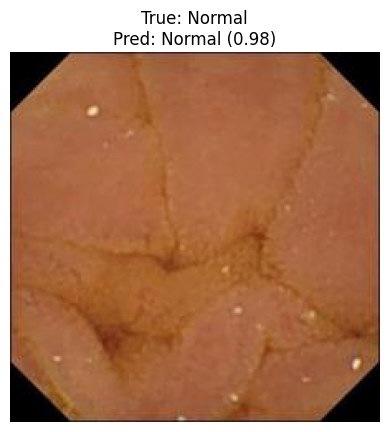

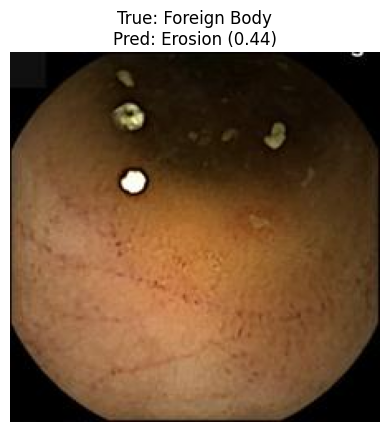

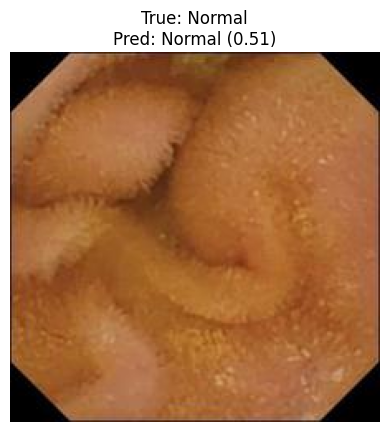

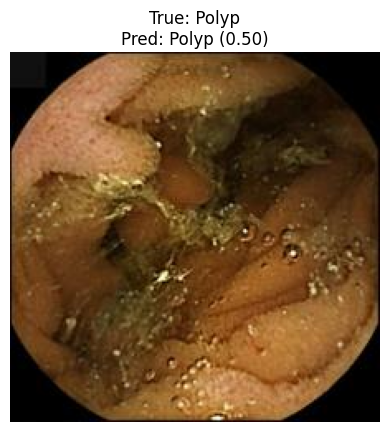

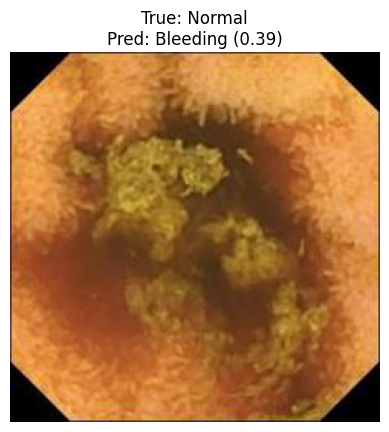

In [27]:
show_predictions(5)

In [28]:
!pip install grad-cam

In [29]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

# correct layer
target_layer = model.blocks[-1][-1].conv_pwl

cam = GradCAM(model=model, target_layers=[target_layer])

def show_gradcam(idx):

    model.eval()

    img, label = val_ds[idx]

    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    grayscale_cam = cam(input_tensor=input_tensor)[0]

    rgb = img.permute(1,2,0).cpu().numpy()
    rgb = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-8)

    vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(5,5))
    plt.imshow(vis)
    plt.title(f"Class: {train_ds.classes[label]}")
    plt.axis("off")
    plt.show()

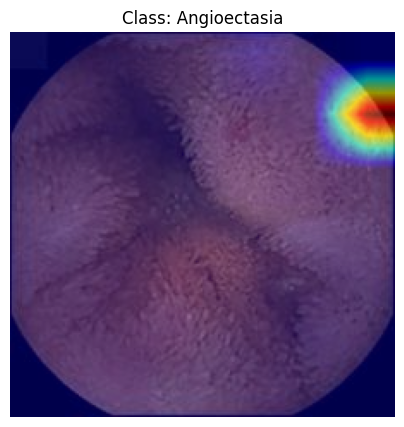

In [30]:
show_gradcam(5)

In [31]:
print(target_layer)

Conv2d(2688, 448, kernel_size=(1, 1), stride=(1, 1), bias=False)


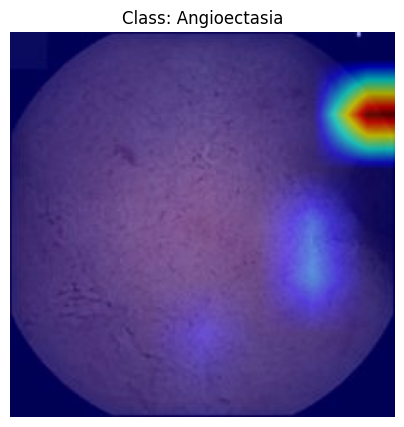

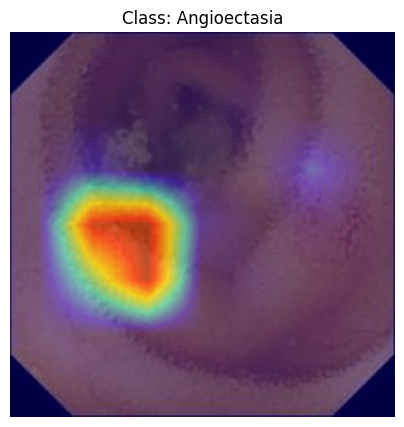

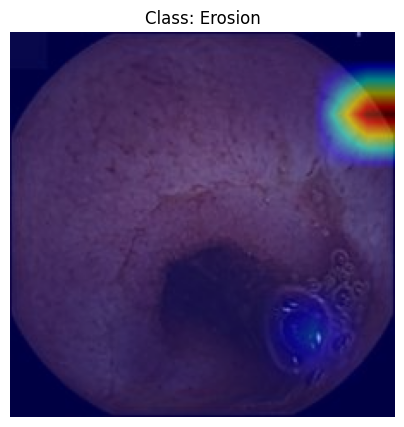

In [32]:
show_gradcam(200)
show_gradcam(450)
show_gradcam(900)

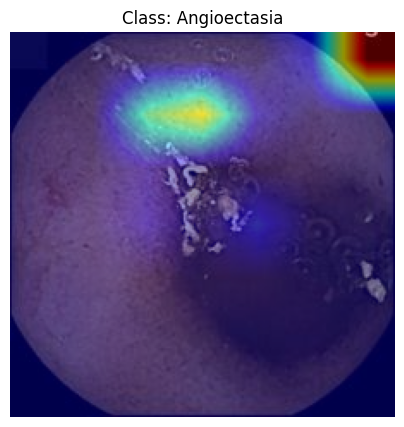

In [33]:
show_gradcam(10)

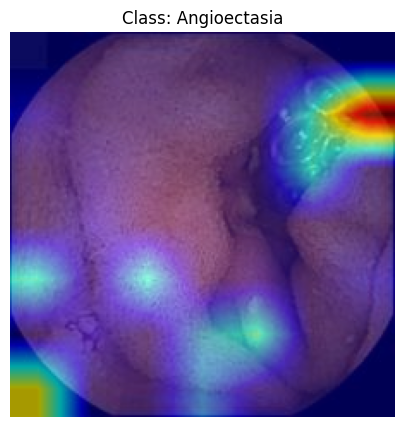

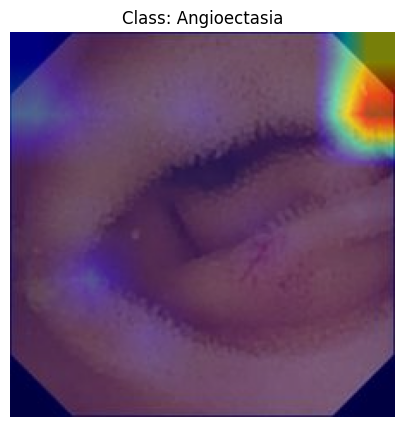

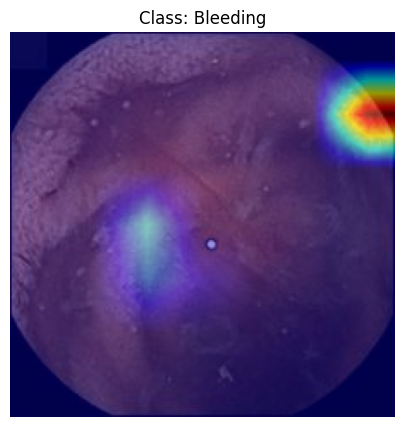

In [34]:
show_gradcam(120)
show_gradcam(350)
show_gradcam(700)

In [35]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

target_layer = model.blocks[-1][-1].conv_pwl
cam = GradCAM(model=model, target_layers=[target_layer])

def show_gradcam(idx):

    model.eval()

    img, label = val_ds[idx]

    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    grayscale_cam = cam(input_tensor=input_tensor)[0]

    rgb = img.permute(1,2,0).cpu().numpy()
    rgb = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-8)

    vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    # ---------- DISPLAY ----------
    fig, ax = plt.subplots(1,2, figsize=(10,4))

    ax[0].imshow(rgb)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title(f"GradCAM → {train_ds.classes[label]}")
    ax[1].axis("off")

    plt.show()

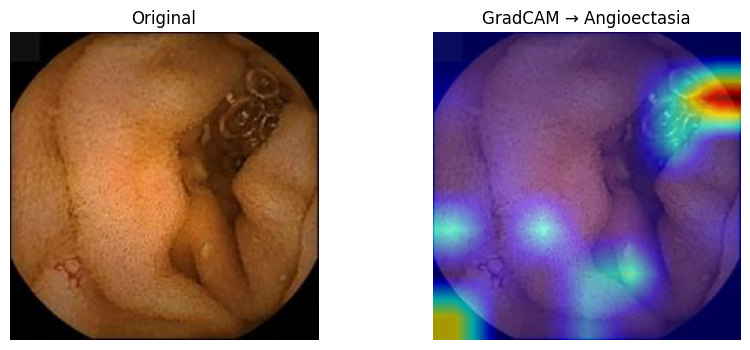

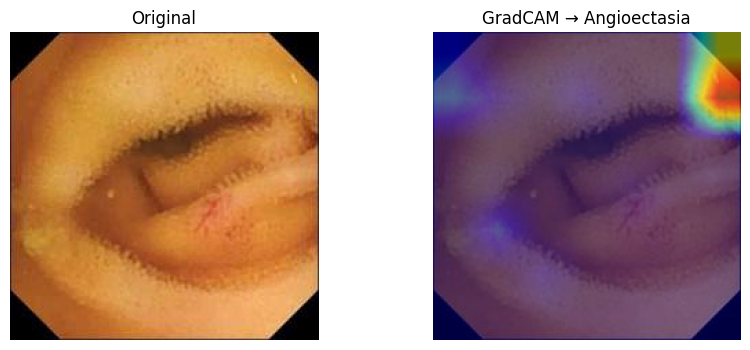

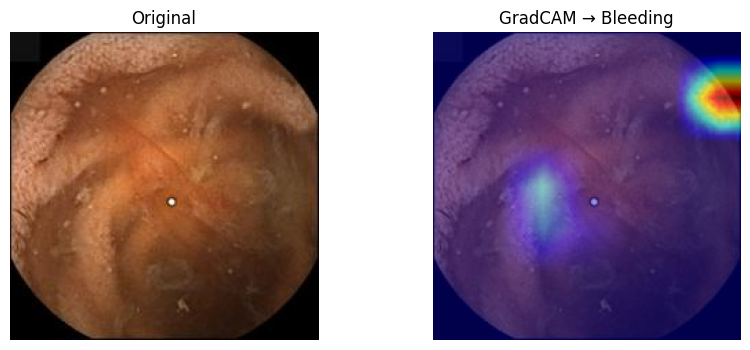

In [36]:
show_gradcam(120)
show_gradcam(350)
show_gradcam(700)

In [37]:
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

# use slightly earlier layer for better spatial detail
target_layer = model.blocks[-2][-1].conv_pwl

cam = GradCAM(model=model, target_layers=[target_layer])

def show_gradcam(idx):

    model.eval()

    img, label = val_ds[idx]

    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    grayscale_cam = cam(input_tensor=input_tensor)[0]

    rgb = img.permute(1,2,0).cpu().numpy()
    rgb = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-8)

    vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    fig, ax = plt.subplots(1,2, figsize=(10,4))

    ax[0].imshow(rgb)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title(f"GradCAM++ → {train_ds.classes[label]}")
    ax[1].axis("off")

    plt.show()

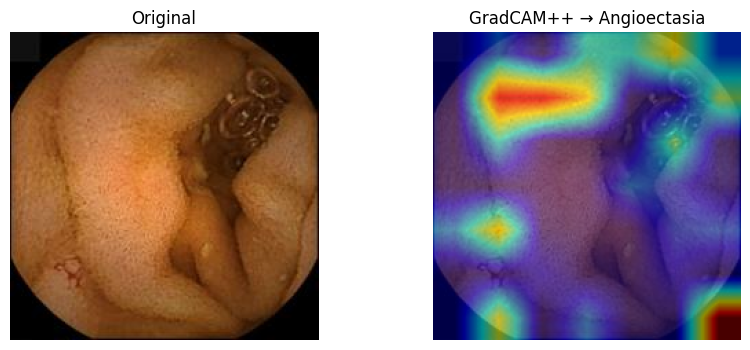

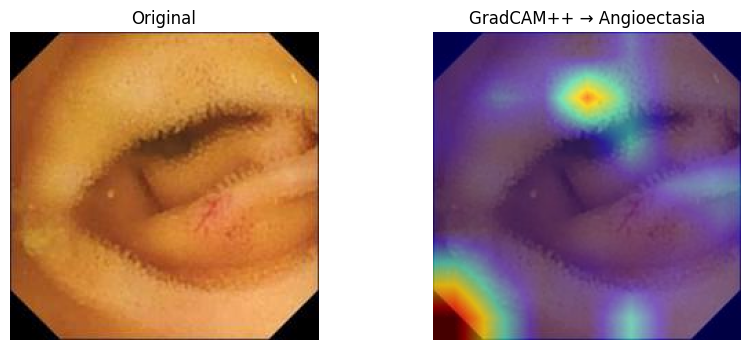

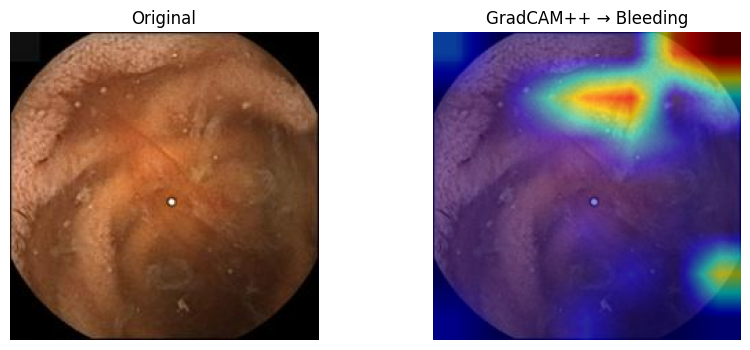

In [38]:
show_gradcam(120)
show_gradcam(350)
show_gradcam(700)

In [40]:
import shutil
shutil.copy("/kaggle/working/best_model.pth", "/kaggle/working/model_backup.pth")

'/kaggle/working/model_backup.pth'

In [41]:
import os

print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/FAAHAA"))
print(os.listdir("/kaggle/input/61.csv"))

['datasets']


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/FAAHAA'

In [42]:
import os
print(os.listdir("/kaggle/input/datasets"))

['himanshurajput123', 'harshit1631']


In [43]:
print(os.listdir("/kaggle/input/datasets/himanshurajput123"))

['faahaa']


In [45]:
import os
PATIENT_FOLDER = "/kaggle/input/datasets/himanshurajput123/faahaa/61"
CSV_PATH = "/kaggle/input/datasets/harshit1631/61.csv/61.csv"
print("Patient exists:", os.path.exists(PATIENT_FOLDER))
print("CSV exists:", os.path.exists(CSV_PATH))

Patient exists: True
CSV exists: False


In [46]:
import os
print(os.listdir("/kaggle/input/datasets/harshit1631"))

['mixeddatasetcapsularendoscopy1', '61-csv']


In [47]:
import os
print(os.listdir("/kaggle/input/datasets/harshit1631/61-csv"))

['61.csv']


In [49]:
import os
PATIENT_FOLDER = "/kaggle/input/datasets/himanshurajput123/faahaa/61"
CSV_PATH = "/kaggle/input/datasets/harshit1631/61-csv/61.csv"
print("Patient OK:", os.path.exists(PATIENT_FOLDER))
print("CSV OK:", os.path.exists(CSV_PATH))

Patient OK: True
CSV OK: True


Total frames: 9601

====== PATIENT REPORT ======

Bleeding → confidence 0.876
Erythema → confidence 0.996
Foreign Body → confidence 0.956
Lymphangiectasia → confidence 0.975
Polyp → confidence 0.880
Worms → confidence 0.999

Ground Truth: ['polyp', 'lymphangioectasis']

MODEL vs TRUTH

Bleeding ✘ false positive
Erythema ✘ false positive
Foreign Body ✘ false positive
Lymphangiectasia ✘ false positive
Polyp ✘ false positive
Worms ✘ false positive
polyp ✘ missed
lymphangioectasis ✘ missed

Showing strongest evidence frames...


Disease: Bleeding


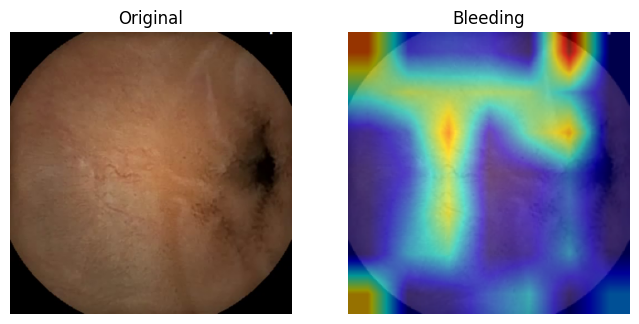


Disease: Erythema


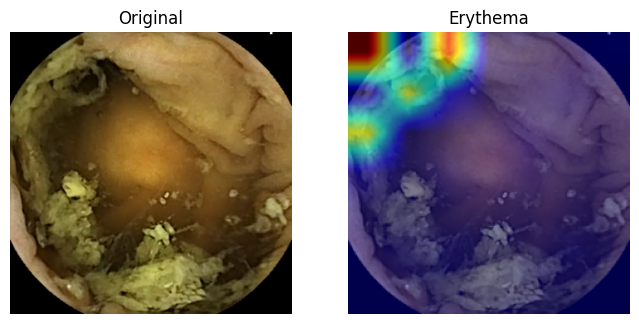


Disease: Foreign Body


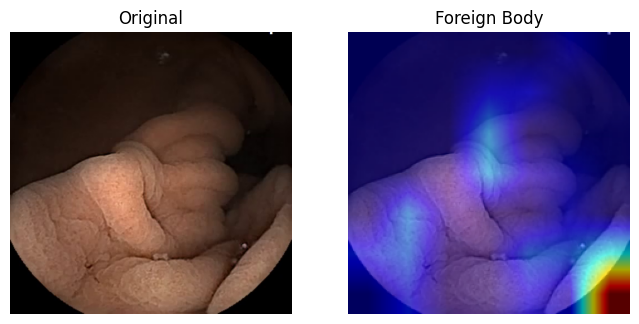


Disease: Lymphangiectasia


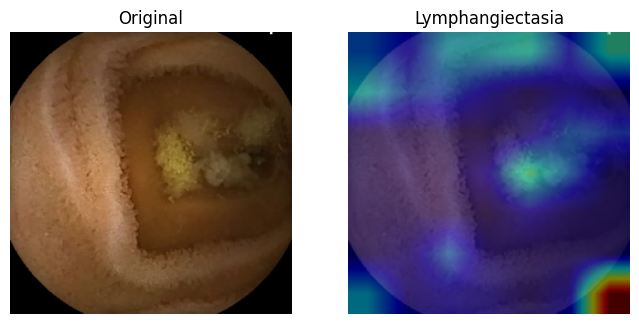


Disease: Polyp


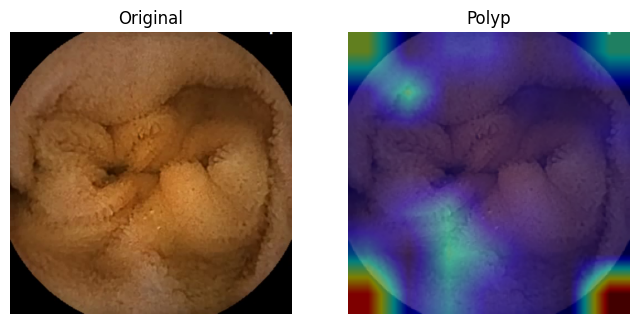


Disease: Worms


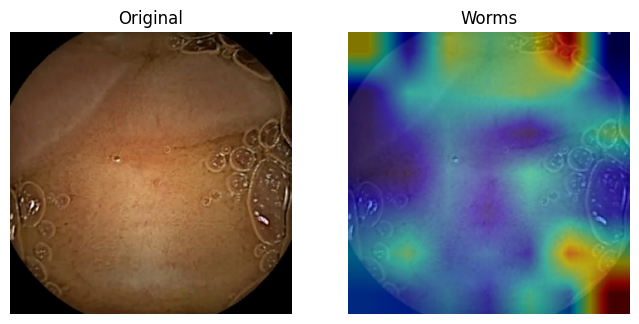

In [52]:
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ======================
# PATHS (CONFIRMED)
# ======================

PATIENT_FOLDER = "/kaggle/input/datasets/himanshurajput123/faahaa/61"
CSV_PATH = "/kaggle/input/datasets/harshit1631/61-csv/61.csv"

TOP_K = 1
CONF_THRESHOLD = 0.85

# ======================
# LOAD CSV
# ======================

df = pd.read_csv(CSV_PATH)

disease_cols = [
    'ulcer','polyp','active bleeding','blood','erythema',
    'erosion','angiectasia','IBD','foreign body',
    'esophagitis','varices','hematin','celiac','cancer','lymphangioectasis'
]

# ======================
# LOAD FRAMES
# ======================

files = sorted([
    f for f in os.listdir(PATIENT_FOLDER)
    if f.lower().endswith((".png",".jpg",".jpeg"))
])

print("Total frames:", len(files))

# ======================
# MODEL PREDICTION
# ======================

model.eval()
results = []

for f in files:

    img = Image.open(os.path.join(PATIENT_FOLDER,f)).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        probs = F.softmax(out,1)[0].cpu().numpy()

    results.append((f,probs))

results = np.array(results, dtype=object)

# ======================
# TOP-K AGGREGATION
# ======================

class_names = train_ds.classes
predictions = {}

for c in range(len(class_names)):

    scores = [(fname,p[c]) for fname,p in results]
    scores = sorted(scores,key=lambda x:x[1],reverse=True)

    top = scores[:TOP_K]
    avg_score = np.mean([s for _,s in top])

    if avg_score > CONF_THRESHOLD:
        predictions[class_names[c]] = (avg_score, top)

# ======================
# REPORT
# ======================

print("\n====== PATIENT REPORT ======\n")

if not predictions:
    print("No abnormalities detected")
else:
    for k,v in predictions.items():
        print(f"{k} → confidence {v[0]:.3f}")

# ======================
# GROUND TRUTH
# ======================

gt = {}
for col in disease_cols:
    if col in df.columns and df[col].sum() > 0:
        gt[col] = True

print("\nGround Truth:", list(gt.keys()))

# ======================
# COMPARISON
# ======================

print("\nMODEL vs TRUTH\n")

for disease in predictions:
    if disease in gt:
        print(disease,"✔ correct")
    else:
        print(disease,"✘ false positive")

for disease in gt:
    if disease not in predictions:
        print(disease,"✘ missed")

# ======================
# GRADCAM VISUALIZATION
# ======================

target_layer = model.blocks[-2][-1].conv_pwl
cam = GradCAM(model=model, target_layers=[target_layer])

print("\nShowing strongest evidence frames...\n")

for disease,(score,top) in predictions.items():

    print("\nDisease:", disease)

    for fname,_ in top[:2]:

        path = os.path.join(PATIENT_FOLDER,fname)
        img = Image.open(path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)
        img_t.requires_grad=True

        heat = cam(input_tensor=img_t)[0]

        rgb = np.array(img.resize((224,224))) / 255.0
        vis = show_cam_on_image(rgb, heat, use_rgb=True)

        fig,ax = plt.subplots(1,2,figsize=(8,4))

        ax[0].imshow(img)
        ax[0].set_title("Original")
        ax[0].axis("off")

        ax[1].imshow(vis)
        ax[1].set_title(disease)
        ax[1].axis("off")

        plt.show()